In [22]:
import pandas as pd

#Leitura do arquivo
df_sem_alta = pd.read_pickle('../../dados_sem_alta_favoravel_desfavoravel.pickle')



In [23]:
df_sem_alta.columns

Index(['AP_PRIPAL', 'AP_UFMUN', 'AP_CNSPCN', 'AP_NUIDADE', 'AP_SEXO',
       'AP_RACACOR', 'AP_MUNPCN', 'AP_UFNACIO', 'AP_DTINIC', 'AP_DTFIM',
       'AP_MOTSAI', 'AP_TRANSF', 'AP_CIDCAS', 'AP_CIDSEC', 'AQ_LINFIN',
       'AQ_ESTADI', 'AQ_GRAHIS', 'AQ_TRANTE', 'AQ_CONTTR', 'AP_APACANT',
       'ESQUEMA_TERAPEUTICO', 'NUMERO_DE_TRATAMENTOS_ANTERIORES',
       'NUMERO_DE_DIAGNOSTICOS_DIFERENTES', 'TEM_CAUSAS_ASSOCIADAS',
       'TEM_CAUSAS_SECUNDARIA', 'INICIO', 'ESTADIAMENTO_INICIO', 'FIM',
       'ESTADIAMENTO_FIM', 'DIF_ESTADIAMENTO', 'TOTAL_TRATAMENTOS',
       'PROCEDIMENTO_INICIAL', 'DESFECHO', 'CODIGO_6D', 'PACLITAXEL',
       'DOXORRUBICINA', 'CICLOFOSFAMIDA', 'FLUOROURACILA', 'METOTREXATO',
       'EPIRRUBICINA', 'DOCETAXEL', 'TRASTUZUMABE', 'TAMOXIFENO',
       'CAPECITABINA', 'LETROZOL', 'ANASTROZOL', 'CARBOPLATINA', 'EXEMESTANO',
       'FULVESTRANTO', 'VINORELBINA', 'GENCITABINA', 'GOSSERELINA',
       'PAMIDRONATO', 'PERTUZUMABE', 'CISPLATINA', 'LEUPRORRELINA',
       'ABRE

In [24]:
df_sem_alta.info()

<class 'pandas.core.frame.DataFrame'>
Index: 53104 entries, 918696 to 408788
Data columns (total 59 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   AP_PRIPAL                          53104 non-null  object 
 1   AP_UFMUN                           53104 non-null  object 
 2   AP_CNSPCN                          53104 non-null  object 
 3   AP_NUIDADE                         53104 non-null  int64  
 4   AP_SEXO                            53104 non-null  object 
 5   AP_RACACOR                         53104 non-null  int64  
 6   AP_MUNPCN                          53104 non-null  object 
 7   AP_UFNACIO                         53104 non-null  object 
 8   AP_DTINIC                          53104 non-null  float64
 9   AP_DTFIM                           53104 non-null  float64
 10  AP_MOTSAI                          53104 non-null  int64  
 11  AP_TRANSF                          53104 non-null  in

In [25]:
df_sem_alta.head()

,AP_PRIPAL,AP_UFMUN,AP_CNSPCN,AP_NUIDADE,AP_SEXO,AP_RACACOR,AP_MUNPCN,AP_UFNACIO,AP_DTINIC,AP_DTFIM,...,VINORELBINA,GENCITABINA,GOSSERELINA,PAMIDRONATO,PERTUZUMABE,CISPLATINA,LEUPRORRELINA,ABREVIATURA_PROTOCOLO,Total_Medicamentos,VALOR_DESFECHO
918696,0304040029,SP,|{{~~ü|}|ä~{{{â,72,F,1,SP,Brasil,1.243555e+09,1.248998e+09,...,0,0,0,0,0,0,0,DOX,1,0
1073812,0304040029,SP,|{{~~ü|}|ä~{{{â,72,F,1,SP,Brasil,1.257811e+09,1.264896e+09,...,0,0,0,0,0,0,0,PTX,1,0
397157,0304040029,ES,|{{~é{ââ|ü{{{Ç,70,F,3,ES,Brasil,1.623715e+09,1.630368e+09,...,0,0,0,0,0,0,0,CFX,1,0
408520,0304040185,ES,|{{~é{ââ|ü{{{Ç,71,F,3,ES,Brasil,1.631059e+09,1.638230e+09,...,0,0,0,0,0,0,0,DTX,1,0
13567415,0304040029,RJ,|{{|éâÇ{{{Ç,60,F,2,RJ,Brasil,1.277942e+09,1.285805e+09,...,0,0,0,0,0,0,0,DOX+CFX+5FU,3,0


In [26]:
from sklearn.preprocessing import LabelEncoder

# Cria o codificador
le_uf = LabelEncoder()

# Aplica o encoder na coluna AP_UFMUN
df_sem_alta['AP_UFMUN_NUM'] = le_uf.fit_transform(df_sem_alta['AP_UFMUN'])

# Visualiza o mapeamento original -> número
uf_mapping = dict(zip(le_uf.classes_, le_uf.transform(le_uf.classes_)))
print("Mapeamento UF -> Número:")
print(uf_mapping)


Mapeamento UF -> Número:
{'ES': 0, 'MG': 1, 'RJ': 2, 'SP': 3}


In [29]:
import pandas as pd
import numpy as np
from sklearn.feature_selection import mutual_info_classif

# Suponha que df seja seu DataFrame original
# E que 'DESFECHO' seja a variável com 'Óbito' ou 'Alta'

# 1. Lista das variáveis numéricas e binárias que serão analisadas
numerical_cols = ['AP_PRIPAL', 'AP_DTINIC', 'AP_DTFIM',
    'AP_NUIDADE', 'AP_RACACOR', 'AP_MOTSAI', 'AP_TRANSF',
    'NUMERO_DE_TRATAMENTOS_ANTERIORES', 'NUMERO_DE_DIAGNOSTICOS_DIFERENTES',
    'TEM_CAUSAS_ASSOCIADAS', 'TEM_CAUSAS_SECUNDARIA',
    'ESTADIAMENTO_INICIO', 'ESTADIAMENTO_FIM', 'DIF_ESTADIAMENTO',
    'TOTAL_TRATAMENTOS', 'PROCEDIMENTO_INICIAL', 'Total_Medicamentos','AP_UFMUN_NUM'
]

medicamentos = [
    'PACLITAXEL', 'DOXORRUBICINA', 'CICLOFOSFAMIDA', 'FLUOROURACILA',
    'METOTREXATO', 'EPIRRUBICINA', 'DOCETAXEL', 'TRASTUZUMABE', 'TAMOXIFENO',
    'CAPECITABINA', 'LETROZOL', 'ANASTROZOL', 'CARBOPLATINA', 'EXEMESTANO',
    'FULVESTRANTO', 'VINORELBINA', 'GENCITABINA', 'GOSSERELINA', 'PAMIDRONATO',
    'PERTUZUMABE', 'CISPLATINA', 'LEUPRORRELINA'
]



# 3. Selecionar X e y
X = df_sem_alta[numerical_cols + medicamentos]
y = df_sem_alta['VALOR_DESFECHO']

# 4. Calcular a Informação Mútua
mi_scores = mutual_info_classif(X, y, discrete_features='auto', random_state=42)

# 5. Organizar os resultados em um DataFrame e pegar o top 15
mi_series = pd.Series(mi_scores, index=X.columns)
top_15 = mi_series.sort_values(ascending=False)

# Exibir as top variáveis
print(top_15)


DIF_ESTADIAMENTO                     0.496017
ESTADIAMENTO_FIM                     0.143653
ESTADIAMENTO_INICIO                  0.094103
AP_DTINIC                            0.086598
AP_DTFIM                             0.078154
PROCEDIMENTO_INICIAL                 0.051106
AP_UFMUN_NUM                         0.040082
AP_MOTSAI                            0.020641
TOTAL_TRATAMENTOS                    0.012705
AP_PRIPAL                            0.008635
TEM_CAUSAS_SECUNDARIA                0.007820
DOXORRUBICINA                        0.006682
Total_Medicamentos                   0.006125
TEM_CAUSAS_ASSOCIADAS                0.005383
NUMERO_DE_DIAGNOSTICOS_DIFERENTES    0.002936
DOCETAXEL                            0.002652
EPIRRUBICINA                         0.002466
ANASTROZOL                           0.002226
EXEMESTANO                           0.001850
AP_NUIDADE                           0.001528
FLUOROURACILA                        0.001265
CAPECITABINA                      

Acurácia: 0.9659176500125534
Precisão: 0.9262122276879832
Recall (Sensibilidade): 0.9772011121408711
F1 Score: 0.951023721475602
ROC AUC: 0.9904718295730575


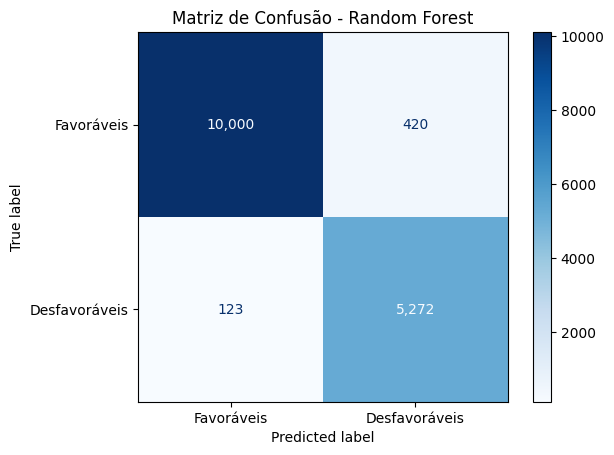

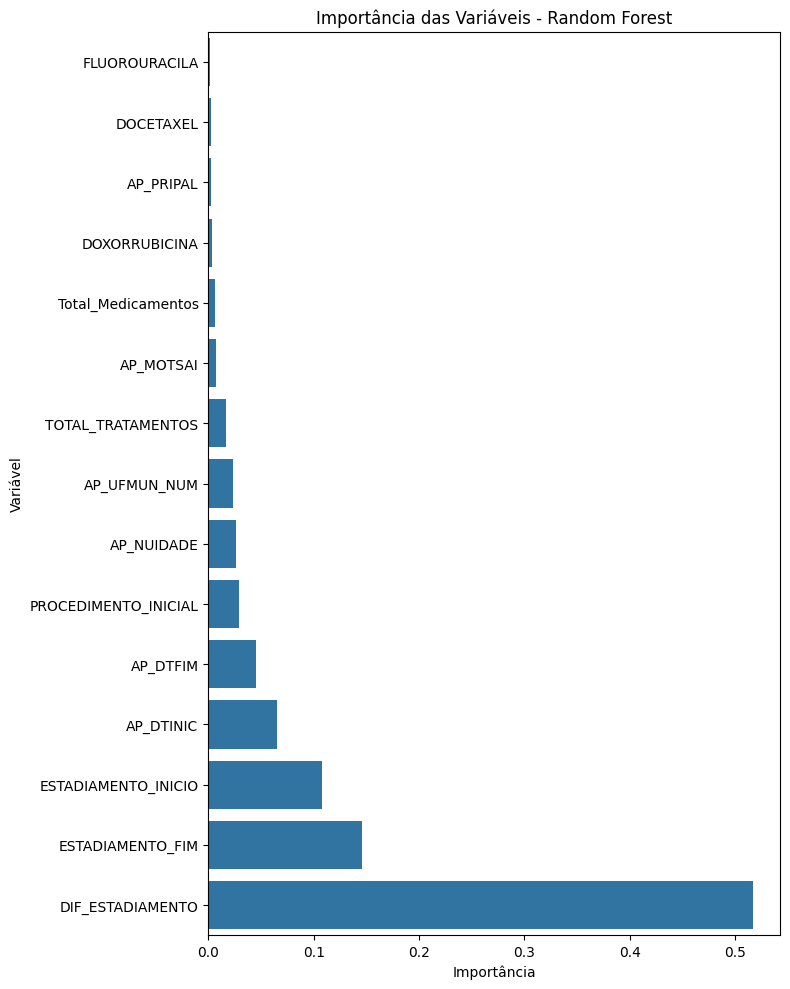

In [35]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, roc_auc_score,
    confusion_matrix, ConfusionMatrixDisplay
)
import matplotlib.pyplot as plt
import seaborn as sns

# 1. VARIÁVEIS SELECIONADAS
variaveis_selecionadas = [
    'DIF_ESTADIAMENTO', 'ESTADIAMENTO_FIM', 'ESTADIAMENTO_INICIO',
    'AP_DTINIC', 'AP_DTFIM', 'PROCEDIMENTO_INICIAL', 'AP_UFMUN_NUM',
    'AP_MOTSAI', 'TOTAL_TRATAMENTOS', 'AP_PRIPAL',
    'DOXORRUBICINA', 'Total_Medicamentos',
    'DOCETAXEL',
    'AP_NUIDADE', 'FLUOROURACILA'
]

# 2. ENCODER PARA VARIÁVEIS CATEGÓRICAS
label_cols = ['AP_PRIPAL']  # pode incluir outras se necessário

for col in label_cols:
    le = LabelEncoder()
    df_sem_alta[col] = le.fit_transform(df_sem_alta[col].astype(str))

# 3. DEFINIR X E y
X = df_sem_alta[variaveis_selecionadas]
y = df_sem_alta['VALOR_DESFECHO']

# 4. TREINO / TESTE
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

# 5. TREINAR RANDOM FOREST
rf = RandomForestClassifier(random_state=42, class_weight='balanced')
rf.fit(X_train, y_train)

# 6. PREVISÕES
y_pred = rf.predict(X_test)
y_proba = rf.predict_proba(X_test)[:, 1]

# 7. AVALIAÇÃO
print("Acurácia:", accuracy_score(y_test, y_pred))
print("Precisão:", precision_score(y_test, y_pred))
print("Recall (Sensibilidade):", recall_score(y_test, y_pred))
print("F1 Score:", f1_score(y_test, y_pred))
print("ROC AUC:", roc_auc_score(y_test, y_proba))

# 8. MATRIZ DE CONFUSÃO (corrigido para exibir inteiros legíveis)
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Favoráveis", "Desfavoráveis"])
fig, ax = plt.subplots()
disp.plot(cmap='Blues', ax=ax)
for text in ax.texts:
    text.set_text(f'{int(float(text.get_text())):,}')
plt.title("Matriz de Confusão - Random Forest")
plt.show()

# 9. IMPORTÂNCIA DAS VARIÁVEIS
importancias = pd.Series(rf.feature_importances_, index=X.columns).sort_values()

plt.figure(figsize=(8, 10))
sns.barplot(x=importancias, y=importancias.index)
plt.title("Importância das Variáveis - Random Forest")
plt.xlabel("Importância")
plt.ylabel("Variável")
plt.tight_layout()
plt.show()



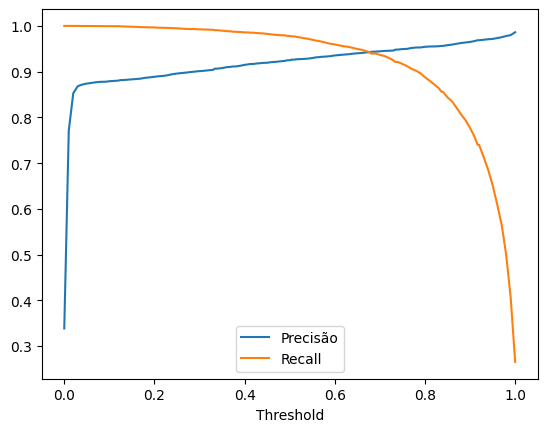

F1 Score com threshold ajustado: 0.9490587920421091


In [44]:
from sklearn.metrics import precision_recall_curve

probs = rf.predict_proba(X_test)[:, 1]
precision, recall, thresholds = precision_recall_curve(y_test, probs)

import matplotlib.pyplot as plt

plt.plot(thresholds, precision[:-1], label="Precisão")
plt.plot(thresholds, recall[:-1], label="Recall")
plt.xlabel("Threshold")
plt.legend()
plt.show()

# Exemplo de escolher threshold baseado no trade-off
best_threshold = 0.4  # só exemplo, você escolhe conforme gráfico

y_pred_threshold = (probs >= best_threshold).astype(int)
print("F1 Score com threshold ajustado:", f1_score(y_test, y_pred_threshold))


scale_pos_weight: 1.95


c:\Users\Rafaela\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\training.py:183: UserWarning: [21:38:30] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Acurácia: 0.9656665829776551
Precisão: 0.9193771626297578
Recall (Sensibilidade): 0.9849860982391103
F1 Score: 0.9510514541387025
ROC AUC: 0.9917744198628198


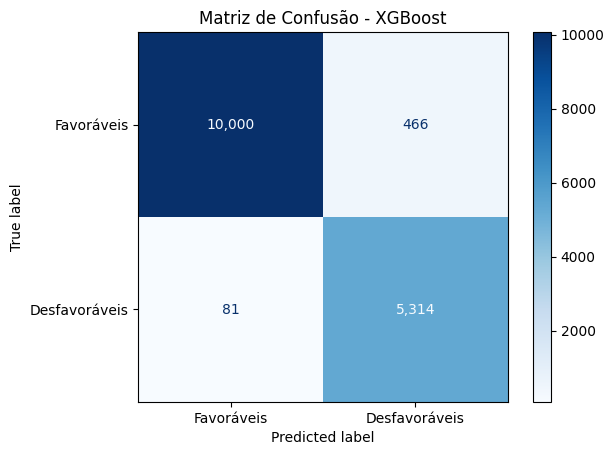

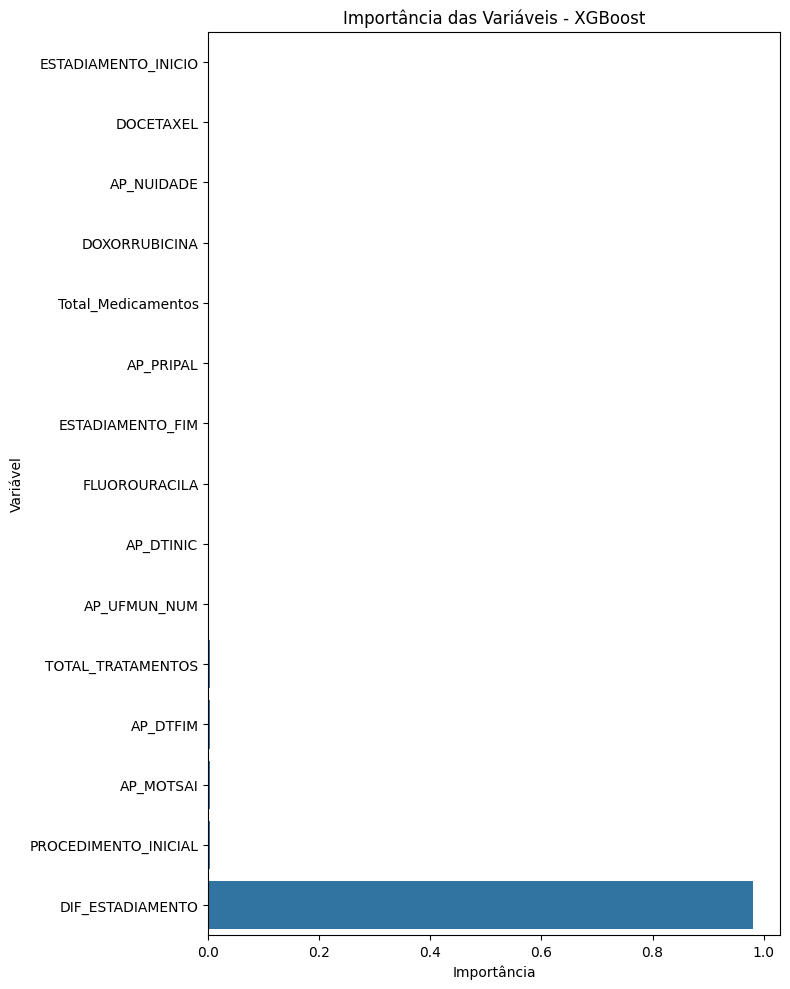

In [37]:
import xgboost as xgb
from collections import Counter

# 1. Calcular scale_pos_weight
contagem = Counter(y_train)
negativos = contagem[0]
positivos = contagem[1]
scale_pos_weight = negativos / positivos

print(f"scale_pos_weight: {scale_pos_weight:.2f}")

# 2. Criar o modelo XGBoost
xgb_model = xgb.XGBClassifier(
    random_state=42,
    scale_pos_weight=scale_pos_weight,
    use_label_encoder=False,
    eval_metric='logloss'  # evita warning na versão recente do XGBoost
)

# 3. Treinar o modelo
xgb_model.fit(X_train, y_train)

# 4. Fazer previsões
y_pred = xgb_model.predict(X_test)
y_proba = xgb_model.predict_proba(X_test)[:, 1]

# 5. Avaliar
print("Acurácia:", accuracy_score(y_test, y_pred))
print("Precisão:", precision_score(y_test, y_pred))
print("Recall (Sensibilidade):", recall_score(y_test, y_pred))
print("F1 Score:", f1_score(y_test, y_pred))
print("ROC AUC:", roc_auc_score(y_test, y_proba))

# 6. Matriz de Confusão
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Favoráveis", "Desfavoráveis"])
fig, ax = plt.subplots()
disp.plot(cmap='Blues', ax=ax)
for text in ax.texts:
    text.set_text(f'{int(float(text.get_text())):,}')
plt.title("Matriz de Confusão - XGBoost")
plt.show()

# 7. Importância das variáveis
importancias = pd.Series(xgb_model.feature_importances_, index=X.columns).sort_values()

plt.figure(figsize=(8, 10))
sns.barplot(x=importancias, y=importancias.index)
plt.title("Importância das Variáveis - XGBoost")
plt.xlabel("Importância")
plt.ylabel("Variável")
plt.tight_layout()
plt.show()


accuracy: 0.9637 ± 0.0021
precision: 0.9251 ± 0.0064
recall: 0.9714 ± 0.0018
f1: 0.9477 ± 0.0028
roc_auc: 0.9906 ± 0.0010


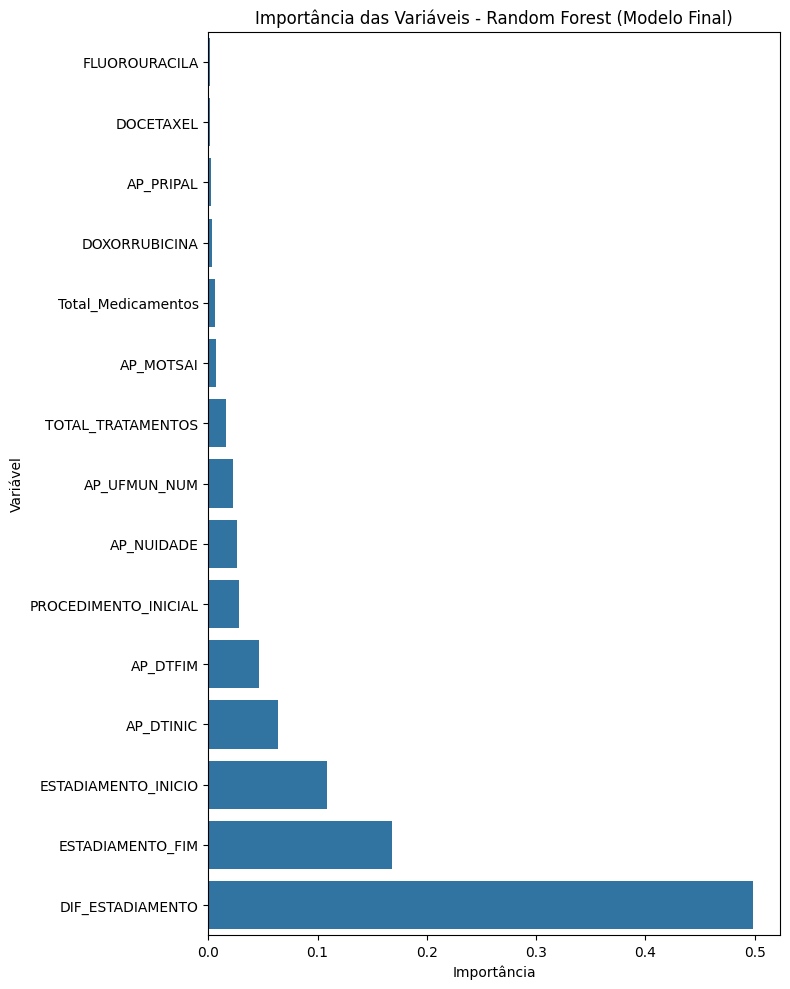

In [45]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold, cross_validate
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, roc_auc_score,
    confusion_matrix, ConfusionMatrixDisplay, make_scorer
)
import matplotlib.pyplot as plt
import seaborn as sns

# 1. VARIÁVEIS SELECIONADAS
variaveis_selecionadas = [
    'DIF_ESTADIAMENTO', 'ESTADIAMENTO_FIM', 'ESTADIAMENTO_INICIO',
    'AP_DTINIC', 'AP_DTFIM', 'PROCEDIMENTO_INICIAL', 'AP_UFMUN_NUM',
    'AP_MOTSAI', 'TOTAL_TRATAMENTOS', 'AP_PRIPAL',
    'DOXORRUBICINA', 'Total_Medicamentos',
    'DOCETAXEL',
    'AP_NUIDADE', 'FLUOROURACILA'
]

# 2. ENCODER PARA VARIÁVEIS CATEGÓRICAS
label_cols = ['AP_PRIPAL']  # pode incluir outras se necessário

for col in label_cols:
    le = LabelEncoder()
    df_sem_alta[col] = le.fit_transform(df_sem_alta[col].astype(str))

# 3. DEFINIR X E y
X = df_sem_alta[variaveis_selecionadas]
y = df_sem_alta['VALOR_DESFECHO']

# 4. CONFIGURAR O RANDOM FOREST
rf = RandomForestClassifier(random_state=42, class_weight='balanced')

# 5. DEFINIR CROSS-VALIDATION E MÉTRICAS
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

metrics = {
    'accuracy': 'accuracy',
    'precision': 'precision',
    'recall': 'recall',
    'f1': 'f1',
    'roc_auc': 'roc_auc'
}

# 6. RODAR CROSS-VALIDATION
results = cross_validate(
    rf, X, y,
    cv=skf,
    scoring=metrics,
    return_train_score=False
)

# 7. EXIBIR MÉDIAS E DESVIO PADRÃO DAS MÉTRICAS
for metric in metrics.keys():
    mean = results[f'test_{metric}'].mean()
    std = results[f'test_{metric}'].std()
    print(f"{metric}: {mean:.4f} ± {std:.4f}")

# 8. TREINAR MODELO FINAL NO CONJUNTO TODO (opcional)
rf.fit(X, y)

# 9. IMPORTÂNCIA DAS VARIÁVEIS NO MODELO FINAL
importancias = pd.Series(rf.feature_importances_, index=X.columns).sort_values()

plt.figure(figsize=(8, 10))
sns.barplot(x=importancias, y=importancias.index)
plt.title("Importância das Variáveis - Random Forest (Modelo Final)")
plt.xlabel("Importância")
plt.ylabel("Variável")
plt.tight_layout()
plt.show()
